# Latent Stability Analysis

In this notebook, we perform latent stability analysis for the trained CAE and trained ESN. 
We load the trained models and compute the LEs of the ESN.

In [61]:
import matplotlib as mpl
import pickle
import json
from pathlib import Path
import torch
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".95"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
import jax
jax.config.update("jax_enable_x64", True)
device = torch.device("cuda:0")
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')

sys.path.append('../')
from neuralnetwork.autoencoder import CAE
from neuralnetwork.preprocessing import generate_esn_noise_data, train_valid_test_split
from stabilitytools.kaplanyorke import kaplan_yorke_dim
sys.path.insert(0, '../../EchoStateNetwork/') # you need to get the git repo https://github.com/MagriLab/EchoStateNetwork
from esn.esn import ESN
from esn.validation import validate
from esn.utils import errors, scalers
from esn.lyapunov_elise import calculate_LEs_less_storage, calculate_LEs

#### 1: Load the latent space data and the parameters of the KS data

In [59]:
cae_path = Path('../weights/fluent-sweep-2/')
with open(cae_path/'ks.json') as f:
    ks_data = json.load(f)
    print(ks_data)

with open(cae_path / 'encoded_ks.npy', 'rb') as f:
    U_encoded = np.load(f)

{'upsample': 4, 'L': 22, 'N_data': 400000, 'N_trans': 1000, 'dt': 0.005, 'Nx': 512, 'train_ratio': 0.8, 'valid_ratio': 0.1, 'batchsize': 128, 'normtype': 'max', 'lyap': 0.04}


#### 2: Load the best hyperparamerts of the ESN and train it

In [3]:
U_esn = generate_esn_noise_data(U_encoded, 1, sigma_n=1e-3)
u_encoded_train, u_encoded_valid, u_encoded_test = train_valid_test_split(U_esn, ks_data)

# Extract the shape of the original data
total_samples, dim = u_encoded_train.shape
N_washout = 100
train_size = min(len(u_encoded_train) - N_washout - 101, 100001)  
val_size = min(len(u_encoded_valid) - 101 - N_washout, 20001)

# Split the data into different datasets
U_washout = u_encoded_train[:N_washout, ...]
U_train_input = u_encoded_train[N_washout: N_washout + train_size - 1, ...]
U_train_label = u_encoded_train[N_washout + 1: N_washout + train_size, ...]
U_val_input = u_encoded_valid[: val_size - 1, ...]
U_val_label = u_encoded_valid[1:val_size, ...]
U_test_washout = u_encoded_test[:N_washout, ...]
U_test = u_encoded_test[N_washout:, ...]

N_val = 2000  # number of validation steps

with open(cae_path / 'esn_best_dict.pkl', 'rb') as f:
    esn_loaded_dict = pickle.load(f)


ESN_dict = esn_loaded_dict
for j in range(0, 5):
    my_ESN = ESN(
        reservoir_size=ESN_dict["reservoir_size"],
        dimension=dim,
        reservoir_connectivity=ESN_dict["reservoir_connectivity"],
        spectral_radius=ESN_dict["spectral_radius"][j],
        input_scaling=ESN_dict["input_scaling"][j],
        tikhonov=ESN_dict["tikhonov"][j],
        input_bias=ESN_dict["input_bias"],
        output_bias=ESN_dict["output_bias"],
        reservoir_weights_mode=ESN_dict["reservoir_weights_mode"],
        input_normalization=ESN_dict["input_normalization"],
        input_weights_mode=ESN_dict["input_weights_mode"],
        #   leak_factor =min_dict['leak_factor'][i],
        input_seeds=[0, 1, 2],
        reservoir_seeds=[3, 4],
        verbose=False,
    )
my_ESN.train(U_washout, U_train_input, U_train_label)

/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.02269e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


#### 3: Perform stability analysis
- predict with the ESN 
- calculate its Jacobian 
- propagate the tangent equation 

In [60]:
N_start = 500
N_plot = 50000
reservoir, prediction = my_ESN.closed_loop_with_washout(
    u_encoded_test[N_start:N_start+N_washout, :dim], N_plot)

In [54]:
N_lyap = int(1 / ks_data["lyap"] /( ks_data["dt"]* ks_data["upsample"]))
LEs, FTLE, QQ, RR = calculate_LEs(
    my_ESN.calculate_constant_jacobian(),
    reservoir[:50 * N_lyap,],
    1 * N_lyap,
    0.2,
    target_dim=10,
)
LEs

array([[ 1.99322950e-01, -1.18567243e-01,  9.36068776e-02, ...,
        -2.41660737e-01, -1.10110979e+00, -7.50708316e-01],
       [ 2.03349401e-01, -1.15277445e-01,  1.18598481e-01, ...,
        -2.39832484e-01, -9.73518641e-01, -7.36511700e-01],
       [ 2.06371518e-01, -1.11917129e-01,  1.41199439e-01, ...,
        -2.38114632e-01, -8.61865274e-01, -9.08934578e-01],
       ...,
       [ 5.23670131e-02,  3.57925873e-03, -3.82468575e-05, ...,
        -3.11087566e-01, -7.69795217e-01, -7.69961820e-01],
       [ 5.23657661e-02,  3.58447394e-03, -3.93978198e-05, ...,
        -3.11090107e-01, -7.69790852e-01, -7.69963130e-01],
       [ 5.23648400e-02,  3.58932448e-03, -4.03061122e-05, ...,
        -3.11093083e-01, -7.69802464e-01, -7.69935566e-01]])

#### 5: Compare the stability properties
- load the reference LEs

In [55]:
with open("../data/KS22_LEs.npy", "rb") as f:
    LEs_ref = np.load(f)

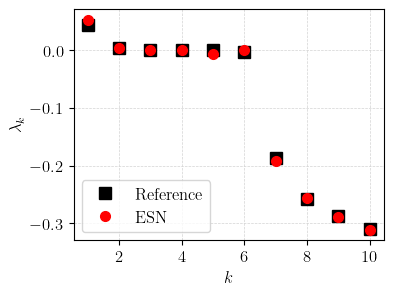

In [56]:
n_lyap = 10

LEs_esn = np.insert(LEs, [3, 4], 0.0, axis=1) # augment with zero

fullspace = np.arange(1, n_lyap + 1)
fs = 12
ax = plt.figure(figsize=(4, 3)).gca()
plt.rcParams.update({'font.size': fs})
plt.grid(True, c='lightgray', linestyle='--', linewidth=0.5)
plt.ylabel(r'$\lambda_k$', fontsize=fs)
plt.xlabel(r'$k$', fontsize=fs)

# Plot the reference LEs
plt.plot(fullspace, LEs_ref[:n_lyap], 'ks', markersize=8, label='Reference')

# Plot the mean of the ESN LEs
plt.plot(fullspace, LEs_esn[-1, :n_lyap], 'ro', markersize=7, label='ESN ')
plt.legend()

plt.show()
# plt.savefig"../images/KS_L22_LEs.png", dpi=100, bbox_inches='tight')

#### 5: Calculate the Kaplan-Yorke dimension

In [63]:
print(f"Kaplan-Yorke dimension of the reference {kaplan_yorke_dim(LEs_ref)}")
print(f"Kaplan-Yorke dimension of the reference {kaplan_yorke_dim(LEs_esn[-1])}")

Kaplan-Yorke dimension of the reference 6.006640751981428
Kaplan-Yorke dimension of the reference 6.007993452075066


#### 6: CLV calculation
The CLV calculation is extremely time-intensive. We provide the code but we recommend implementing it in a seperate script. 
Calculate the CLVs from Q and R. Based on the CLVs, compute the angles.

In [9]:
# from clv_tools import clvs
# V = clvs.compute_V(QQ, RR, (ks_data["dt"] * ks_data["upsample"]))
# clv_idx = [(0, 2), (0, 6), (2, 6)]
# costhetas, thetas = clvs.compute_thetas(V, clv_idx=clv_idx)